<a href="https://colab.research.google.com/github/gvogiatzis/CS4740/blob/main/CS4740_Lab_Week_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# [CS4740 Labs] Lab 7: Reinforcement Learning

##Introduction

In this lab we will look at one of the most exciting (and genuinely fun) aspects of Deep Learning which is the way deep neural networks can be taught to solve AI tasks. We will move from networks that make simple inferences (e.g. classification or regression) onto networks that can actually make decisions on which action to take, based on world observations received.

The AI paradigm we will be using is Reinforcement Learning, a powerful abstraction of problem solving, which of course has been around for ages. The exciting part of deep learning, is that for the first time we were able to solve Reinforcement Learning problems from raw, unstructured observations, for example the screen pixels of Atari games, instead of hand-crafted features.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1vE2Z_KC__bhRqFeDiedOPfja7Rf7hZKF'/>
<figcaption>Atari games</figcaption></center>
</figure>


This type of Reinforcement Learning is of course a much more difficult problem but thankfuly deep learning technologies were designed for exactly these situations. It turns out that all the famous Q-learning algorithms can be given the deep learning, end-to-end training treatment, which in many cases leads to very elegant RL agents that can solve what appear to be very difficult tasks.


Let's begin by installing a few libraries, that are required for rendering atari games on the jupyter notebook (colab) environment.

In [1]:
!pip install gym > /dev/null 2>&1
!apt install swig cmake > /dev/null 2>&1
!pip install box2d box2d-kengz > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

And let's also import the key modules for OpenAI gym and pytorch.

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# To activate virtual display 
# need to run a script once for training an agent as follows
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

## Tabular Q-learning with the Taxi driver task

But before we get busy with the challenging Deep RL problems such as Atari, it's a good idea to start with something easier just so we refresh the fundamentals of RL.

We will therefore start with the "Taxi" problem. This is a small-scale problem (with only 500 possible states) that models a taxi driver picking up passengers and dropping them off to various locations. Let's initialize the Taxi environment from OpenAI gym:

In [52]:
env = gym.make('Taxi-v3')

Let's now find out about the state/observation space and the action space:

In [53]:
print(env.observation_space)
print(env.action_space)

Discrete(500)
Discrete(6)


So this task has 500 different states and 6 possible actions. Let's see what the initial state looks like:




In [54]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square (yellow box) and the passenger is at a random location (designated with a blue letter). The taxi drives to the passenger's location, picks up the passenger (becoming a green box when that happens), drives to the passenger's destination (another one of the four specified locations designated with a magenda letter), and then drops off the passenger. Once the passenger is dropped off, the episode ends.


There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 

There are 6 discrete deterministic actions:
0. move south
1. move north
2. move east
3. move west
4. pickup passenger
5. drop off passenger


The rewards given at each state for each action are as follows: There is a default per-step reward of -1, except for delivering the passenger, which is +20, or executing "pickup" and "drop-off" actions illegally, which is -10.



We can use `env.action_space.sample()` to sample a random action and the game is stepped through using the `env.step(action)` method that we saw in lectures. Let's try a completely random agent, using the `env.render(mode='ansi')` to render the game state into a string instead of `stdout`.

In [55]:
frames=[]

done=False

S = env.reset()
while not done:
    A = env.action_space.sample()
    S_new, R, done, _ = env.step(A)
    S=S_new
    frames.append(env.render(mode='ansi'))

We can now print each state sequentially and see  the game running as an animation.

In [56]:
from IPython.display import clear_output
from time import sleep

for i,f in enumerate(frames):
    clear_output(wait=True)
    print(f"{i+1}/{len(frames)}")
    print(f)
    sleep(.2)

200/200
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)



As you probably guessed already, this doesn't look great, because the agent is just randomly choosing actions to take. We need to apply some RL training to get some intelligent behaviour. One of the most well established algorithms, almost synonymous with RL over many decades, is Q-learning. The idea is very simple: We maintain a table of Q-values, i.e. estimates of how valuable a particular state/action combination is. And since we do not know the exact values for each state/action, we can use the previous Q-values stored, together with the reward currently obtained. 

The way this works is as follows:

Suppose the agent finds itself in state $s$, and decides to perform action $a$ while in that state. Then the system gives out a reward $r$ and the new state $s'$. Our current estimate of the value of the current state action combination is $Q(s,a)$. Where can we get a better estimate? Well, we are currently receiving reward $r$ and we will be getting some future rewards, call them $G$, which we must discount to the present, using discount factor $\gamma$. So the correct value we would like to store in $Q(s,a)$ is 
$$r + \gamma G$$

The only slight snag is that we don't know $G$, the value of all future rewards from state $s'$ onwards. But now we remember we have some $Q$ estimates already. Can we use those? Well, since our new state is $s'$, if we then take action $a'$, the total amount of reward we expect to get is currently estimated as $Q(s',a')$. But of course we will not be choosing any old action $a'$! We will be choosing the best one, i.e. the one that maximizes $Q(s',a')$. So the value we can expect to get from state $s'$ is currently estimated as:
$$\max_{a'} Q(s',a').$$
Putting that together with the current reward $r$, our estimate for the value of the $s$,$a$ combination becomes:
$$r+\gamma \max_{a'} Q(s',a')$$

This expression above we will call the 'target'. The basis of the Q-learning algorithm is the computation of these target values, and the gradual pushing of the old Q-values towards the targets. In plain old vanilla Q-learning, in each iteration we will be moving the old Q-value a fraction of the way towards the target. The fraction is given by parameter $\alpha$ so the final update formula looks like:

$$Q(s,a) := (1-\alpha)Q(s,a) + \alpha (r+\gamma \max_{a'} Q(s',a'))$$

Because this version of the problem essentially involves creating a table of Q-values, it is known as tabular Q-learning (or just Q-learning). There are many options in python for the data structure that will represent our Q-value estimates. The most elegant is through a dictionary `Q` who's keys are the states. For each state `S`, it records an
numpy array `[q1,q2,...,q6]` that stores our current estimates for the values of the six possible actions we can take at state `S`. So to find the value of the combination of state `S` with action `A` (where `A` is a number betwee 0 and 5) we would write

`Q[S][A]`

To get the value of the best action when in state `S` we would use the `.max()` method on the numpy array, to give

`Q[S].max()`

And to find out the index of that best action (useful when we are selecting which action to follow) we would use the `.argmax()` method. So the best action to follow when in state `S` would be given by:

`Q[S].argmax()`

Let's see the python implementation of tabular Q-learning in full:

In [58]:
from collections import defaultdict
from random import random,choice

env = gym.make('Taxi-v3')

# Q-learning parameters
alpha = 0.5
gamma = 0.6
epsilon = 0.1
num_of_episodes = 3000

# Q[S][A] stores the estimated value of taking action A when in state S
Q = defaultdict(lambda: np.zeros(env.action_space.n))

frames,rewards=[],[]

for e in range(num_of_episodes):
    S = env.reset()
    done=False
    totalR=0
    while not done:
        # Epsilon-greedy strategy        
        A = env.action_space.sample() if random()<epsilon else Q[S].argmax()

        # Executing action, receiving reward and new state
        S_new, R, done, _ = env.step(A)
                
        # target is an estimate of the value of current state and action
        # It is given by Bellman update formula if the state is non-terminal
        # For final states, it is just the reward received.
        target = R + gamma * Q[S_new].max() if not done else R

        # moving the existing Q-value towards the target by a factor of alpha
        Q[S][A] += alpha * (target - Q[S][A])
        S = S_new
        
        # monitoring of training progress
        totalR += R
        # picking a few episodes to record as animation sequences.
        if e in [100,200,995,996,997,998,999]: 
            frames.append({'e':e, 'frame':env.render(mode='ansi')})
    rewards.append(totalR)
env.close()

We can now plot the rewards received at each training episode

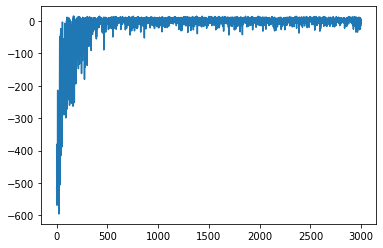

In [59]:
plt.plot(rewards)

The plot seems to indicate the algorithm has succeeded but it is a bit noisy, due to the random element in the task. We can remove some of that noise by computing a rolling average of the rewards. The numpy `convolve` method is quite handy for that:

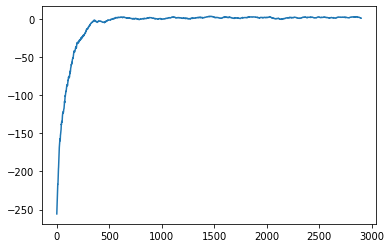

In [60]:
plt.plot(np.convolve(rewards, [0.01]*100,'valid'),'-')

The algorithm seems to be earning a good amount of rewards. But what about the policy it has learned? Can it actually solve the task? Let's look at the images.

In [62]:
from IPython.display import clear_output
from time import sleep

for f in frames:
    clear_output(wait=True)
    print(f"e={f['e']+1}")
    print(f['frame'])
    sleep(.2)

e=1000
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



After some uncertain early runs it seems that towards the end Q-learning has indeed learned the correct policy. The taxi agent is able to ferry passengers to and from each of the four locations. 

## Lunar Landing with Deep Q-learning

We are now ready to tackle something a bit more challenging. 

In [64]:
env = Monitor(gym.make('LunarLander-v2'),directory='./video',force=True)

In [ ]:
env.action_space.

At each step, the agent is provided with the current state of the space vehicle which is an 8-dimensional vector of real values, indicating the horizontal and vertical positions, orientation, linear and angular velocities, state of each landing leg (left and right). The agent then has to make one of four possible actions, namely do nothing, fire left orientation engine, fire main engine, or fire right orientation engine. These are 4 levers the agent must learn to control in order to land safely.

In [4]:
s = env.reset()
done=False
while not done:
    a = env.action_space.sample()
    s,r,done,_=env.step(a)

env.close()

NameError: ignored

In [4]:
class MLPnet(nn.Module):
    def __init__(self, *sizes):
        self.num_actions = sizes[-1]
        super(MLPnet, self).__init__()
        self.layers = nn.ModuleList()
        for s,s_ in zip(sizes[:-1],sizes[1:]):
            self.layers.append(nn.Linear(s,s_))
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [5]:
class TorchWrapper(gym.ObservationWrapper):
    def observation(self, observation):
        return torch.tensor(observation, device=device, dtype=torch.float)

In [6]:
def epsilon_greedy(epsilon, S, qnet, env):
    if random() < epsilon:
        return env.action_space.sample()
    else:
        return qnet(S).argmax().item()

In [7]:
def sample(data, batchsize):
    import random
    size = min(len(data),batchsize)
    return random.sample(data, size)

In [8]:
def updateQNet(qvalue, target, optimiser, loss):
    L = loss(qvalue, target)
    optimiser.zero_grad()
    L.backward()
    optimiser.step()

In [9]:
from collections import deque
from random import random,sample

In [ ]:
env = TorchWrapper(Monitor(gym.make('LunarLander-v2'),directory='./video',force=True,video_callable=lambda i:i%10==0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


epsilon = 0.2
rewards=[]
gamma = 0.9
num_episodes=2000
num_actions = env.action_space.n
state_size = env.observation_space.shape[0]
batchsize=64


# qnet = MLPnet(state_size,50,100,num_actions).to(device)
qnet = MLPnet(state_size,100,500,num_actions).to(device)
optim = torch.optim.Adam(qnet.parameters(), lr= 0.001)
loss = nn.MSELoss()

for e in range(num_episodes):
    done = False
    S = env.reset()
    tot_reward=0

    # epsilon = max(0.1, epsilon*0.99)
    while not done:
        A = epsilon_greedy(epsilon, S, qnet, env) 
        S_new, R, done, _ = env.step(A)

        R = torch.tensor(R,device=device, dtype=torch.float)

        target = R + gamma * qnet(S_new).max() if not done else R
        qvalue = qnet(S)[A]
        updateQNet(qvalue, target,optim,loss)

        tot_reward += R
        S = S_new
        
    rewards.append(tot_reward)
    print(f"\r{e}/{num_episodes} tot_reward={tot_reward}",end='')


# print(f"Average reward:{sum(rewards[-50:])/50}")
# return rewards, replaybuffer

783/2000 tot_reward=-3.408106803894043

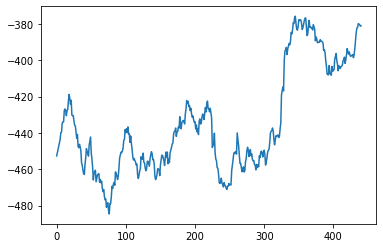

In [11]:
plt.plot(np.convolve(rewards,[0.01]*100,'valid'),'-')

In [ ]:
def updateQNet_batch(qnet, batch, optimizer, loss):
    s,a,r,s_new,d = batch
    
    s=torch.stack(s)
    s_new=torch.stack(s_new)
    r=torch.tensor(r,device=device,dtype=torch.float)
    d=torch.tensor(d,device=device,dtype=torch.bool)
    a=torch.tensor(a,device=device,dtype=torch.int64)

    with torch.no_grad():
        qmax,_ = qnet(s_new).view(-1,num_actions).max(dim=1)
        target = torch.where(d, r, r + gamma * qmax).view(-1,1)
    L = loss(qnet(s).gather(1,a.view(-1,1)),target)
    optim.zero_grad()
    L.backward()
    optim.step()

In [ ]:
env = TorchWrapper(Monitor(gym.make('LunarLander-v2'),directory='./video',force=True,video_callable=lambda i:i%10==0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


epsilon = 1
rewards=[]
gamma = 0.99
num_episodes=1000
num_actions = env.action_space.n
state_size = env.observation_space.shape[0]
batchsize=64

replaybuffer = deque(maxlen=100000)


qnet = MLPnet(state_size,64,64,32,num_actions)
optim = torch.optim.Adam(qnet.parameters(), lr= 0.001)
loss = nn.MSELoss()

for e in range(num_episodes):
    done = False
    S = env.reset()
    tot_reward=0

    epsilon = max(0.1, epsilon*0.99)
    while not done:
        A = epsilon_greedy(epsilon, S, qnet, env) 
        S_new, R, done, _ = env.step(A)
        replaybuffer.append((S,A,R,S_new,done))

        tot_reward += R
        S = S_new
        batch = sample(replaybuffer,batchsize)
        batch = zip(*batch)
        
        updateQNet_batch(qnet, batch, optimizer, loss)
    rewards.append(tot_reward)
    print(f"\r{e}/{num_episodes} tot_reward={tot_reward}",end='')


# print(f"Average reward:{sum(rewards[-50:])/50}")
# return rewards, replaybuffer